In [1]:
#In this first part we import all the libraries we will be using in the GRB analysis
import numpy as np

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import chainconsumer
%matplotlib inline
%matplotlib notebook
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
from threeML import *


import warnings


warnings.simplefilter("ignore")


WARNING UserWarning: Using default configuration from /home/henrique/anaconda3/envs/threeML/lib/python3.7/site-packages/threeML/data/threeML_config.yml. You might want to copy it to /home/henrique/.threeML/threeML_config.yml to customize it and avoid this warning.


WARNING RuntimeWarning: Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


WARNING RuntimeWarning: Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


WARNING RuntimeWarning: Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML



In [2]:
#here we access the entire GBM catalog to find a specific GRB for analysing, 
#we can also search them in hearsac website

gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB090618353")

Building cache for fermigbrst.



name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB090618353,293.990,78.358,55000.3530863,112.386


In [3]:
#after choosing the GRB we take all of it's information for the analysis 
#such as what the detectors triggered and are relavant for the analysis
#the interval the GRB occured, the background interval and the best fit model
#also we can see the bestfit model and its parameters
grb_info =  gbm_catalog.get_detector_information()["GRB090618353"]

gbm_detectors = grb_info['detectors']
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model =  gbm_catalog.get_model(best_fit_model, "fluence")["GRB090618353"]
display(grb_info)

{'source': {'fluence': '7.936000-120.322000', 'peak': '63.488000-64.512000'},
 'background': {'pre': '-34.380000--6.250000',
  'post': '204.170000-284.380000',
  'full': '-34.380000--6.250000,204.170000-284.380000'},
 'trigger': 'bn090618353',
 'detectors': array(['n4', 'b0'], dtype='<U2'),
 'best fit model': {'fluence': 'band', 'peak': 'comp'},
 'ra': 293.99,
 'dec': 78.3576}

In [4]:
#here we get from GBM database the main files of the triggered detectors, the tte data for the lightcurve
#the cspec file for the spectrum and the rsp response files
dload = download_GBM_trigger_data("bn090618353",detectors=gbm_detectors)

Auto-determined polynomial order: 2




Binned 2-order polynomial fit with the Powell method



Saved fitted background to n4_bkg.h5.

Successfully restored fit from n4_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 9-900 translates to channels 5-123
Now using 119 channels out of 128
Now using 119 bins


Auto-determined polynomial order: 0




Binned 0-order polynomial fit with the Powell method



Saved fitted background to b0_bkg.h5.

Successfully restored fit from b0_bkg.h5
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-900 translates to channels 1-19
Now using 19 channels out of 128
Now using 19 bins


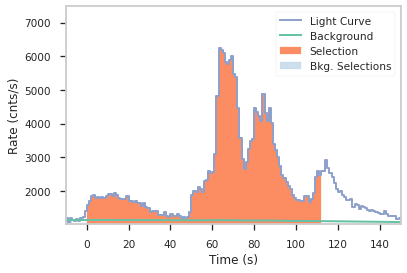

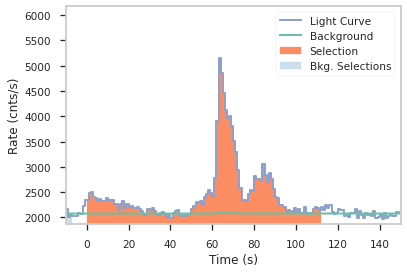

In [5]:
#Here we are creating a loop to reach every triggered detector of the GRB

fluence_plugins = []
time_series = {}
for det in gbm_detectors:


#Here we are selecting the spectrum files and the responses (we use cspec files because it has more energy bins
#and it has a better time resolution)
    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"])
    
#This part is responsible for fitting the background by a specific polynomial from the files loaded above
    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

#Now we construct the light curve for the GRB from the tte files and using the fitted background file created above   
    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",)

#Here we are plotting the light curve first we select the time interval in which the analysis will happen
#Second we choose the time range of the light curve plotted
    time_series[det] = ts_tte

    ts_tte.set_active_time_interval('0 - 112.386')

    ts_tte.view_lightcurve(-10, 150)
    
#Here we are building the spectrum that will be analysed, first we choose  the spectrum to be a dispersion of the
#full file spectrum against the background and latter we will choose the energy bins used
    
    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-900")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.)

    fluence_plugins.append(fluence_plugin)

In [23]:
#defining the time bins for the analysis
n3 = time_series['n4']
time_edges = np.array([0,45])

starts = time_edges[:-1]

stops = time_edges[1:]

n3.create_time_bins(start=starts, stop=stops, method='custom')



#here we are taking out the bad bins, the one after 15 seconds in this example
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5E-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i,b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts=edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method='custom')
#only if it has enough binnings 
#n3.view_lightcurve(use_binner=True);

Created 1 bins via custom
Created 1 bins via custom


In [24]:
#here we are defining the bins for the other detectors with the bin of de detector above
time_resolved_plugins = {}
for k,v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Created 1 bins via custom


Created 1 bins via custom


In [25]:
#here we are choosing a model for fitting the spectrum
BBPL = Blackbody() + Powerlaw()

#BCPL.kT_1.bounds = (0,None)
#BBCPL.kT_1.prior =  Gaussian(mu = 25 , sigma = 5)
#BBCPL.K_1.bounds = (0, None)
#BBCPL.K_1.prior =  Log_uniform_prior()
#BBCPL.K_2.prior = Uniform_prior(lower_bound = 1e-30, upper_bound = 1000.0)
#BBCPL.piv_2.bounds = (-3, None)
#BBCPL.piv_2.prior = Gaussian(mu = 1800 , sigma = 100)
#BBCPL.index_2.prior = Gaussian(mu = -1 , sigma = 1)
#BBCPL.xc_2.bounds = (1e-30, None)
#BBCPL.xc_2.prior =  Gaussian(mu = 1800 , sigma = 100)

#The information of ps is the GRB trigger name , it's ra, DEC and spectral model
ps = PointSource('bn160509374', 293.99 , 78.3576 ,spectral_shape=BBPL)
BBPL_model = Model(ps)

In [26]:
#Every time we perform an analysis we need to rerun the binning cells
models = []
results = []
analysis = []
for interval in range(1):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(BBPL_model)


    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():
        
        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-900")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)
    
    # set up the sampler and fit

    #bayes = BayesianAnalysis(this_model, dlist)
    #bayes.set_sampler("multinest")
    #bayes.sampler.setup(n_live_points=500)
    #bayes.sample()
    jl = JointLikelihood(this_model,dlist)
    result = jl.fit()
    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(jl)

Best fit values:



,result,unit
parameter,,
bn160509374.spectrum.main.composite.K_1,(2.5 +/- 0.5) x 10^-5,1 / (cm2 keV3 s)
bn160509374.spectrum.main.composite.kT_1,(3.16 +/- 0.17) x 10,keV
bn160509374.spectrum.main.composite.K_2,(1.16 -0.14 +0.16) x 10,1 / (cm2 keV s)
bn160509374.spectrum.main.composite.index_2,-1.618 +/- 0.029,



Correlation matrix:



1.00,-0.95,-0.63,0.58
-0.95,1.00,0.63,-0.65
-0.63,0.63,1.00,-0.94
0.58,-0.65,-0.94,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
b0_interval0,196.815220
n4_interval0,990.336237
total,1187.151457



Values of statistical measures:



,statistical measures
AIC,2382.603665
BIC,2394.011928


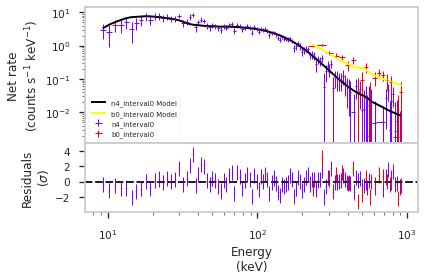

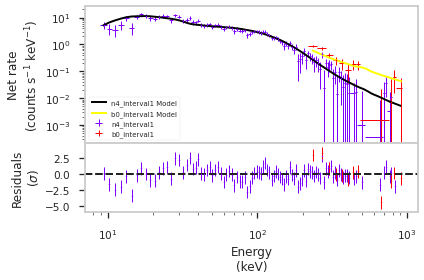

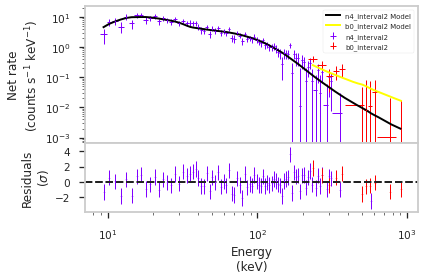

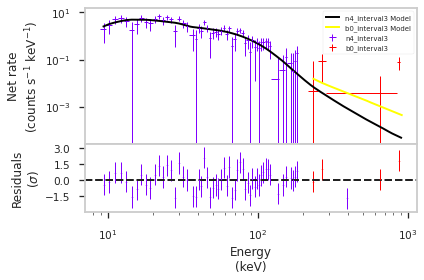

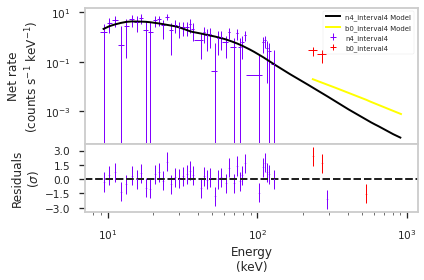

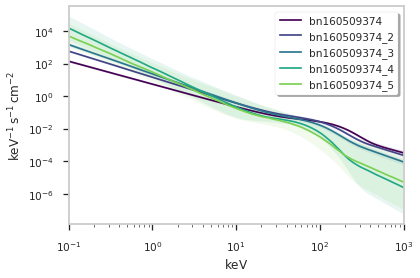

In [77]:
#here we re just plotting the spectrum fitting 
for spectrum in analysis:
    #spectrum.restore_median_fit()
    display_spectrum_model_counts(spectrum, min_rate=[0,0,0,0], step=False)
    #spectrum.results.corner_plot()
plot_spectra(*[a.results for a in analysis[::1]], flux_unit="1/(cm2 s keV)", fit_cmap='viridis', contour_cmap='viridis', contour_style_kwargs=dict(alpha=0.1),
            ene_min = 1, ene_max = 1000);

In [27]:
#this part we are creating an algorithm to calculate the flux, luminosity and energy
#first we calculate the luminosity distance of the GRB by its redshift considering
# a flat universe then we calculate the luminosity, flux and energy and display in a list
luminosity= []
energy = []
i = 0
#the GRB redshift resultcan be found in NASA's website
z = float(input('Sources redshift '))
H_0 = 71/3.086e+24 #km/s cm
q_0 = -0.6
luminosity_distance = 3e5/H_0*z*(1+(1-q_0)*z/2) #cm
display(luminosity_distance)
for spectrum in analysis:
    flux = calculate_point_source_flux(9,1000,spectrum.results,flux_unit='erg/(s cm2)',energy_unit='keV',use_components=True,components_to_use=['Blackbody','Powerlaw','total'])
    luminosity.append(4*3.14159*luminosity_distance*luminosity_distance/(1+z)*flux[0]) 
    energy.append(4*3.14159*luminosity_distance*luminosity_distance/(1+z)*flux[0]*(time_edges[i+1]-time_edges[i]))
    display(flux[0])
    display(luminosity[i]) #ergs/s
    display(energy[i]) #ergs
    #here we calculate the size of the convective bubble in the precursor
    k_T = float(input('Temperature of the blackbody emitter (in keV) '))
    r_em = (luminosity[i]/(1.3e25*k_T**4*(1+z)**4))**(1/2) #cm
    display(r_em)
    i = i+1

Sources redshift 0.34


5.639295549295775e+27

,flux,low bound,hi bound
bn160509374: Blackbody,2.5610445797449345e-07 erg / (cm2 s),1.8382834191142412e-07 erg / (cm2 s),3.392598097124182e-07 erg / (cm2 s)
bn160509374: Powerlaw,5.683441510203849e-07 erg / (cm2 s),4.719691994910572e-07 erg / (cm2 s),6.869451893986933e-07 erg / (cm2 s)
bn160509374: total,8.259477702978556e-07 erg / (cm2 s),6.93604629068065e-07 erg / (cm2 s),9.763893345144755e-07 erg / (cm2 s)


,flux,low bound,hi bound
bn160509374: Blackbody,7.637857460848932e+49 erg / (cm2 s),5.482351552519617e+49 erg / (cm2 s),1.0117817117561667e+50 erg / (cm2 s)
bn160509374: Powerlaw,1.6949847919606425e+50 erg / (cm2 s),1.4075637340068052e+50 erg / (cm2 s),2.0486911791928443e+50 erg / (cm2 s)
bn160509374: total,2.4632415185327637e+50 erg / (cm2 s),2.068551767081888e+50 erg / (cm2 s),2.9119065799539644e+50 erg / (cm2 s)


,flux,low bound,hi bound
bn160509374: Blackbody,3.43703585738202e+51 erg / (cm2 s),2.4670581986338275e+51 erg / (cm2 s),4.55301770290275e+51 erg / (cm2 s)
bn160509374: Powerlaw,7.627431563822892e+51 erg / (cm2 s),6.334036803030623e+51 erg / (cm2 s),9.2191103063678e+51 erg / (cm2 s)
bn160509374: total,1.1084586833397437e+52 erg / (cm2 s),9.308482951868497e+51 erg / (cm2 s),1.310357960979284e+52 erg / (cm2 s)


Temperature of the blackbody emitter (in keV) 45


,flux,low bound,hi bound
bn160509374: Blackbody,666621742.036234 erg(1/2) / (cm s(1/2)),564777179.2962575 erg(1/2) / (cm s(1/2)),767250379.8946799 erg(1/2) / (cm s(1/2))
bn160509374: Powerlaw,993062546.0398325 erg(1/2) / (cm s(1/2)),904956562.7796979 erg(1/2) / (cm s(1/2)),1091771990.7258852 erg(1/2) / (cm s(1/2))
bn160509374: total,1197146217.344092 erg(1/2) / (cm s(1/2)),1097051199.2627947 erg(1/2) / (cm s(1/2)),1301614621.2627203 erg(1/2) / (cm s(1/2))


array([63.34670893, -1.02478769])

array([[ 7.97469023e+01, -1.48314656e+00],
       [-1.48314656e+00,  3.45170899e-02]])

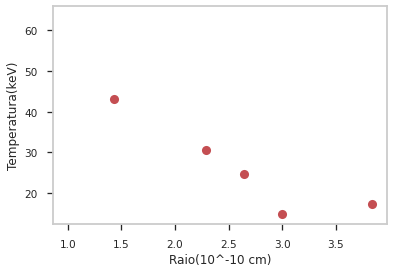

In [103]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.optimize import curve_fit as cfit
import math

radius = [1.43,2.29,2.64,3.84,3]
temperature = [43.2,30.5,24.7,17.4,15]
plt.plot(radius,temperature,'ro')


# essa parte serve para ver o ajuste antes da conversão
#aqui vamos fazer o ajuste nos dados experimentais
#nossa função de ajuste
def ajuste(x,A,B):
    return A*(x)**B

initial_guess = [10,-0.6]

#função responsável por ajustar a curva aos dados
popt , pcov = cfit(ajuste, radius, temperature, initial_guess)
#mostra os valores dos parâmetros e a matriz de covariancia
display(popt)
display(pcov)


#o intervalo no eixo x do plot
time_range = (0,1)

#plotando o ajuste
plt.plot(ajuste(time_range,*popt),color = 'red')
plt.ylabel('Temperatura(keV)')
plt.xlabel('Raio(10^-10 cm)')
plt.show()
